# Changing image according to sound entropy

## Assumptions

Here we will try to study how much information is needed to guess the next note in a song. Similarly to Shannon's theory about the encoding of the English alphabet - looking at the relative frequencies of the most and least used letters. 

Here instead of letters in the alphabet, we will use pitches, such that the cardinality of our alphabet is 12. Therefore, words are chords, sentences are musical phrases and paragraphs are an entire song.

### Definition
_Entropy_: Uncertainty, or information, contained in a message. Measure of likeliness that a sent message will not convey the intended meaning it was given, and it is equal to the number of bits per symbol of improbability that the message contains.

### Entropy in Rythm and Pitch

By inspiration of the work done in "Entropy and the Estimation of Musical Ability" (2016) from Andrew Russell, we will study and extract the _rythmic entropy_ and the _tonal entropy_. Russell uses it as way to find the "musical ability" of a musician in an audio recording. 

In [55]:
import scipy.io.wavfile
import scipy.stats
from os.path import abspath
import subprocess
import numpy as np
from os.path import join as p_join
import matplotlib.pyplot as plt
data_fpath = p_join(abspath(''), 'data')

In [62]:
# we will need some real-world audio for some examples. 
from IPython.display import Audio
from scipy.io import wavfile

# Brandenburg concerto #1, mono, 8 kHz
audio_sample_sf, audio_sample = wavfile.read(p_join(data_fpath, ".wav"))
audio_sample = audio_sample / 32767.0
print("duration:", len(audio_sample), "sample rate:", audio_sample_sf, "length=", len(audio_sample)/audio_sample_sf)
Audio(audio_sample, rate=audio_sample_sf)


duration: 441000 sample rate: 44100 length= 10.0


error: ushort format requires 0 <= number <= (0x7fff * 2 + 1)

In [19]:
def compute_rhythm(song):
    onsets_string = subprocess.check_output(['aubioonset', '-i', song])
    onsets = onsets_string.decode("utf-8").strip().split('\n')
    onsets = [float(onset) for onset in onsets]
    diffs = np.abs(np.diff(onsets))
    grid = np.linspace(0, 10, 1000)
    density = scipy.stats.gaussian_kde(diffs)
    hist = density(grid)
    entropy = scipy.stats.entropy(hist)

    return {
    'entropy': entropy,
    'recording': song,
    'onsets': onsets,
    'diffs': diffs,
    'hist': hist,
    'grid': grid
    }

In [20]:
res = compute_rhythm("./data/brand1.wav")

In [21]:
res

{'entropy': 3.7199008714663524,
 'recording': './data/brand1.wav',
 'onsets': [0.0,
  0.1065,
  0.52425,
  0.879,
  1.24025,
  1.611125,
  1.974375,
  2.353125,
  2.706375,
  3.094625,
  3.447875,
  3.805,
  3.96925,
  4.178125,
  4.353375,
  4.888,
  5.25775,
  5.628625,
  6.00325,
  6.3615,
  6.708375],
 'diffs': array([0.1065  , 0.41775 , 0.35475 , 0.36125 , 0.370875, 0.36325 ,
        0.37875 , 0.35325 , 0.38825 , 0.35325 , 0.357125, 0.16425 ,
        0.208875, 0.17525 , 0.534625, 0.36975 , 0.370875, 0.374625,
        0.35825 , 0.346875]),
 'hist': array([5.83786442e-002, 8.47200552e-002, 1.19392439e-001, 1.63548517e-001,
        2.18005243e-001, 2.83108147e-001, 3.58630327e-001, 4.43714772e-001,
        5.36855846e-001, 6.35906268e-001, 7.38095621e-001, 8.40057828e-001,
        9.37885047e-001, 1.02724563e+000, 1.10361352e+000, 1.16264738e+000,
        1.20072901e+000, 1.21562856e+000, 1.20722198e+000, 1.17815624e+000,
        1.13434786e+000, 1.08520830e+000, 1.04350849e+000, 1.0

In [22]:
def plotAudio(plt, recording):
  sampling_rate, audio = scipy.io.wavfile.read(recording.name)
  duration = len(audio) / sampling_rate

  plt.axis([0, duration, -1, 1])

  audio = audio.mean(axis = 1)
  audio /= np.max(audio)
  audio = scipy.signal.resample(audio, 12000)
  audio = np.asarray(audio, dtype=np.double)
  time = np.linspace(0, duration, num = len(audio))
  plt.plot(time, audio, 'b')

In [46]:
def generateOnsetLocations(values):
    print('ol')

    recording = values['recording']
    onsets = values['onsets']

    plt.title('Onset Locations')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plotAudio(plt, recording)
    for onset in onsets:
        plt.plot([onset, onset], [-1, 1], 'r')

In [39]:
def generateOnsetDiffs(values):
    print('od')

    onsets = values['onsets']
    diffs = values['diffs']

    plt.title('Onset Diffs')
    plt.ylabel('Onset Time Difference (s)')
    plt.xlabel('Time (s)')
    graphDiffs = np.append(diffs, [0])
    plt.plot(onsets, graphDiffs)
    plt.show()

In [47]:
def generateOnsetHistogram(values):
    print('oh')

    diffs = values['diffs']

    plt.title('Onset Diff Histogram')
    plt.ylabel('Count')
    plt.xlabel('Onset Time Difference (s)')
    plt.hist(diffs, bins=500, normed=True)

In [52]:
def generateSmoothedOnsetHistogram(values):
    print('soh')

    diffs = values['diffs']
    hist = values['hist']
    grid = values['grid']

    plt.title('Smoothed Onset Diff Histogram')
    plt.ylabel('Count')
    plt.xlabel('Onset Time Difference (s)')
    bins = plt.hist(diffs, bins=300, density=True)
    histNorm = hist / np.max(hist) * np.max(bins[0])
    end = [i for i, v in enumerate(hist) if v > 1e-4][-1]
    plt.plot(grid[:end], histNorm[:end], 'g-')

od


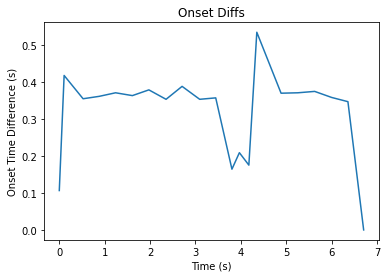

In [40]:
generateOnsetDiffs(res)

soh


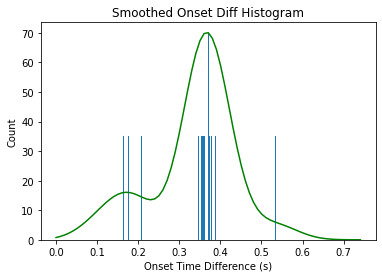

In [53]:
generateSmoothedOnsetHistogram(res)

In [54]:
res['entropy']

3.7199008714663524